# Apply a trading strategy to multiple stocks

This is just a trial. Using following code as starter: https://backtest-rookies.com/2017/08/22/backtrader-multiple-data-feeds-indicators/. 

In [1]:
import backtrader as bt
from datetime import datetime
import yfinance as yf

In [2]:
class maCross(bt.Strategy):
    '''
    For an official backtrader blog on this topic please take a look at:

    https://www.backtrader.com/blog/posts/2017-04-09-multi-example/multi-example.html

    oneplot = Force all datas to plot on the same master.
    '''
    params = (
    ('sma1', 40),
    ('sma2', 200),
    ('oneplot', True)
    )

    def __init__(self):
        '''
        Create an dictionary of indicators so that we can dynamically add the
        indicators to the strategy using a loop. This mean the strategy will
        work with any numner of data feeds. 
        '''
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = dict()
            self.inds[d]['sma1'] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.sma1)
            self.inds[d]['sma2'] = bt.indicators.SimpleMovingAverage(
                d.close, period=self.params.sma2)
            self.inds[d]['cross'] = bt.indicators.CrossOver(self.inds[d]['sma1'],self.inds[d]['sma2'])

            if i > 0: #Check we are not on the first loop of data feed:
                if self.p.oneplot == True:
                    d.plotinfo.plotmaster = self.datas[0]

    def next(self):
        # Loop over each dataset
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            # pos stores current size of the position on this asset
            pos = self.getposition(d).size
            # no market / no orders
            if not pos:  
                # Then buy 1000 shares on bullish crossover
                if self.inds[d]['cross'][0] == 1:
                    self.buy(data=d, size=2000)
                # or sell 1000 shares on bearish crossover
                elif self.inds[d]['cross'][0] == -1:
                    self.sell(data=d, size=2000)
            # means we have positions
            else:
                # case bullish crossover
                if self.inds[d]['cross'][0] == 1:
                    # liquidate (short?) positions
                    self.close(data=d)
                    # then buy
                    self.buy(data=d, size=1000)
                # case bearish crossover
                elif self.inds[d]['cross'][0] == -1:
                    # Liquidate (long?) position
                    self.close(data=d)
                    # then sell
                    self.sell(data=d, size=1000)

    def notify_trade(self, trade):
        dt = self.data.datetime.date()
        if trade.isclosed:
            print('{} {} Closed: PnL Gross {}, Net {}'.format(
                                                dt,
                                                trade.data._name,
                                                round(trade.pnl,2),
                                                round(trade.pnlcomm,2)))

## Load prices from Yahoo Finance

Just do it once. no need to create files again

## Create custom class to read csv file

In [3]:
class yfCSVData(bt.feeds.GenericCSVData):
    """
    Explain format of csv files used
    ----
    Seems to be a file downloaded from Oanda API
    """
    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('openinterest', -1),
    )

## Run backtest

2018-12-17 AAPL Closed: PnL Gross 29301.03, Net 29301.03
2019-04-29 AAPL Closed: PnL Gross -9609.92, Net -9609.92
2022-05-26 AAPL Closed: PnL Gross 87440.19, Net 87440.19
2022-09-07 AAPL Closed: PnL Gross -17591.42, Net -17591.42
2022-10-05 AAPL Closed: PnL Gross -10732.21, Net -10732.21
Final Portfolio Value: $-430435.93830451067
P/L: $-440435.93830451067


<IPython.core.display.Javascript object>


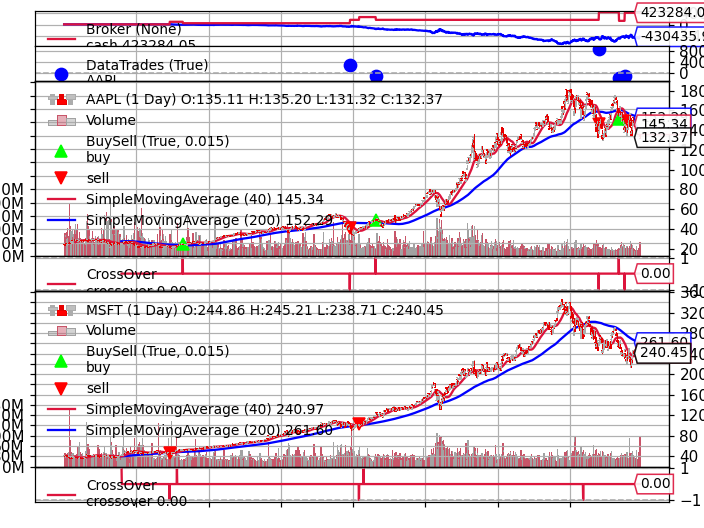

[[<Figure size 640x480 with 8 Axes>]]

In [4]:
#Variable for our starting cash
startcash = 10000

#Create an instance of cerebro
cerebro = bt.Cerebro()

#Add our strategy
cerebro.addstrategy(maCross, oneplot=False)

#create our data list
datalist = [
    ('data/AAPL2015-2022.csv', 'AAPL'), #[0] = Data file, [1] = Data name
    ('data/MSFT2015-2022.csv', 'MSFT'),
]

#Loop through the list adding to cerebro.
for i in range(len(datalist)):
    data = yfCSVData(dataname=datalist[i][0])
    cerebro.adddata(data, name=datalist[i][1])


# Set our desired cash start
cerebro.broker.setcash(startcash)

# Run over everything
cerebro.run()

#Get final portfolio Value
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash

#Print out the final result
print('Final Portfolio Value: ${}'.format(portvalue))
print('P/L: ${}'.format(pnl))

#Finally plot the end results
cerebro.plot(style='candlestick')

Results are strange and it is difficult to understand results. We will need to investigate the next function in class maCross. Seems like buy & sell conditions are not as expected. 